# Simple Example of ParameterWithSetpoints
This notebook provides an example for writing a simple driver with a parameter that has setpoints. Let's name this parameter that has setpoints as "y". Then, the setpoints, say "x1, x2, x3 ..", are the parameters on which the parameter 
"y" depends upon. Meaning "y" is a function of "x1, x2, x3 ..." where "x1, x2, x3 ..." are known as the setpoints of parameter "y".

This is most likely to be useful for instruments that return arrays of results. In this notebook, we will show an example of this.

In [1]:
import numpy as np
import os

In [2]:
from qcodes.dataset.plotting import plot_dataset
from qcodes.utils.validators import Numbers, Arrays
from qcodes.instrument.base import Instrument
from qcodes.dataset.measurements import Measurement

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/210419-7741-qcodes.log


In [3]:
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment

In [4]:
from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter

First, we define a dummy instrument that returns something like a frequency spectrum starting from a frequency given by `f_start` to a frequency given by `f_stop` in `n_points` steps. 

The extra functionality of the `ParameterWithSetpoints` is implemented by giving it a reference to one or more parameters that acts like its setpoints. 

To setup a `ParameterWithSetpoints` we have to do two things in addition to what we do for a normal parameter.

* Define one or more parameter for the setpoints (one for each dimension of the array and let the `ParameterWithSetpoints` know that these are the setpoints.
* Give both the setpoints parameter(s) and the `ParameterWithSetpoints` a `validator` of type `Arrays` with a shape. The shapes should be such that the combined shape of the setpoints matches the shape of the `ParameterWithSetpoints`. Note that if the shape changes with the setting of the instrument, it can be defined by another parameter as shown below. 

In [5]:
class GeneratedSetPoints(Parameter):
    """
    A parameter that generates a setpoint array from start, stop and num points
    parameters.
    """
    def __init__(self, startparam, stopparam, numpointsparam, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._startparam = startparam
        self._stopparam = stopparam
        self._numpointsparam = numpointsparam

    def get_raw(self):
        return np.linspace(self._startparam(), self._stopparam(),
                              self._numpointsparam())

class DummyArray(ParameterWithSetpoints):
    
    def get_raw(self):
        npoints = self.root_instrument.n_points.get_latest()
        return np.random.rand(npoints)
    

class DummySpectrumAnalyzer(Instrument):
    
    def __init__(self, name, **kwargs):
        
        super().__init__(name, **kwargs)
            

        self.add_parameter('f_start',
                           initial_value=0,
                           unit='Hz',
                           label='f start',
                           vals=Numbers(0,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('f_stop',
                           unit='Hz',
                           label='f stop',
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('n_points',
                           unit='',
                           initial_value=10,
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)
        
        self.add_parameter('freq_axis',
                           unit='Hz',
                           label='Freq Axis',
                           parameter_class=GeneratedSetPoints,
                           startparam=self.f_start,
                           stopparam=self.f_stop,
                           numpointsparam=self.n_points,
                           vals=Arrays(shape=(self.n_points.get_latest,)))
                           
        self.add_parameter('spectrum',
                   unit='dBm',
                   setpoints=(self.freq_axis,),
                   label='Spectrum',
                   parameter_class=DummyArray,
                   vals=Arrays(shape=(self.n_points.get_latest,)))
                

In the above example, the shape is defined by the parameter `n_points` that defines how many samples our `DummySpectrumAnalyzer` returns.

This means that the validation will call the function to get `n_points` twice for each `get` of the parameter. This may be too slow, however, if you (as the driver-writer) can guarantee that the cached value for `n_points` will never be out of sync with the value stored in the instrument, `n_points` may be replaced by it's latest known value such that the `validator` reads:
```python
vals=Arrays(shape=(self.n_points.get_latest))
```

This avoids any additional call to the instrument. In the same way, the arguments to the `freq_axis` parameter that defines the start, stop and number of points can be replaced by their latest value if the instrument allows it.



In [6]:
tutorial_db_path = os.path.join(os.getcwd(), 'tutorial_paramter_with_setpoints.db')
initialise_or_create_database_at(tutorial_db_path)
load_or_create_experiment(experiment_name='tutorial_ParameterWithSetpoints', sample_name="no sample")

tutorial_ParameterWithSetpoints#no sample#1@/home/runner/work/Qcodes/Qcodes/docs/examples/Parameters/tutorial_paramter_with_setpoints.db
----------------------------------------------------------------------------------------------------------------------------------------
1-results-1-dmm_setpoints,dmm_current-1
2-results-2-dmm_setpoints,dmm_current-1
3-results-3-dmm_setpoints,dmm_current-1

In [7]:
a = DummySpectrumAnalyzer('foobar')

First we setup the limits of the spectrum

In [8]:
a.f_start(0)
a.f_stop(500)
a.n_points(501)

And we can grab the frequency axis

In [9]:
a.n_points()

501

In [10]:
freq_axis = a.freq_axis()
len(freq_axis)

501

In [11]:
freq_axis[:10]

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

As expected we get a result wit 501 points as we asked for an axis with 501 points. 

Above we have added a validator to the `freq_axis` parameter encoding the fact that this is an Array with `n_points`. Note that we do not have to supply the number of points as an integer but can supply a function that returns the valid number of points. This would normally be a QCoDeS parameter.

This will be checked if we validate the output.

In [12]:
a.freq_axis.validate(a.freq_axis.get())

Naturally, we can also get the spectrum. Getting the spectrum will automatically perform validation both for the shape of the parameter itself and the relation to the setpoint parameter(s)

In [13]:
spectrum = a.spectrum.get()
len(spectrum)

501

When we validate a `ParameterWithSetpoints`, we automatically validate that the shape is consistent between the parameters and its setpoints. As well as validating the shape as above.

In [14]:
a.spectrum.validate(a.spectrum.get())

The consistent shapes can be validated explicitly.

In [15]:
a.spectrum.validate_consistent_shape()

We can inspect the setpoints of the spectrum.

In [16]:
a.spectrum.setpoints

(<__main__.GeneratedSetPoints: freq_axis at 139962241270736>,)

Or even change them.

In [17]:
a.spectrum.setpoints = (a.freq_axis,)

## Measurement

We can also directly consume the parameter in a measurement without defining the setpoints of the parameter again. The setpoints are automatically obtained from the definition of the `ParameterWithSetpoint` instance. 

In [18]:
meas = Measurement()
meas.register_parameter(a.spectrum)

with meas.run() as datasaver:
    datasaver.add_result((a.freq_axis, a.freq_axis()),
                         (a.spectrum, a.spectrum()))
    dataset = datasaver.dataset

Starting experimental run with id: 4. 


And plot it

([<AxesSubplot:title={'center':'Run #4, Experiment tutorial_ParameterWithSetpoints (no sample)'}, xlabel='Freq Axis (Hz)', ylabel='Spectrum ($10^{-3}$ dBm)'>],
 [None])

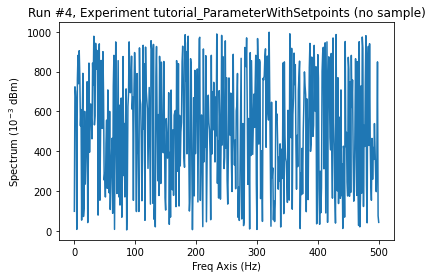

In [19]:
plot_dataset(dataset)

To reduce the amount of typing, if a `ParameterWithSetpoints` is given without its setpoints, the setpoints will be fetched automatically, ``get`` will be called on them, and the obtained data will be added to the results.

Note that it is an error to supply values for some but not all of the setpoints.

## Measure a ParameterWithSetpoints while sweeping another parameter

First we add another parameter. This parameter will just serve the example of having something to sweep 
that is not directly connected to the spectrum.

In [20]:
a.add_parameter('external_param', set_cmd=None)

Now we can sweep the external parameter and measure the parameter with setpoints at each step.

Starting experimental run with id: 5. 


([<AxesSubplot:title={'center':'Run #5, Experiment tutorial_ParameterWithSetpoints (no sample)'}, xlabel='external_param', ylabel='Freq Axis (Hz)'>],
 [<matplotlib.colorbar.Colorbar at 0x7f4b7f852a10>])

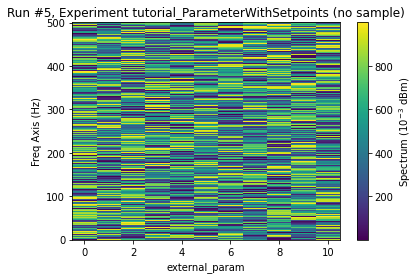

In [21]:
meas = Measurement()
meas.register_parameter(a.external_param)
meas.register_parameter(a.spectrum, setpoints=(a.external_param, ))

with meas.run() as datasaver:
    for b in np.linspace(0,10, 11):
        a.external_param(b)
        datasaver.add_result(
            (a.external_param, b),
            (a.spectrum, a.spectrum.get())
        )
    dataid = datasaver.run_id

plot_dataset(datasaver.dataset)